## Synthetic Factual / Counterfactual Data

Key: Generate 4 auto-correlated variables based on the concept of difussion / advection. Then combine these variables following the causal assumptions:
1. Non-linear causal relationships
2. Confounders for treatment and outcome
3. Spillover effects on +1 neighborhood for indirect treatment effect

In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction
Nt = 5000      # Number of time steps
D_a = 0.01     # Diffusion coefficient for variable a
D_b = 0.01     # Diffusion coefficient for variable b
D_c = 0.01     # Diffusion coefficient for variable c (combination of a and b)
alpha = 0.1    # Influence of variable_a on variable_b
beta = 0.2     # Coefficient for variable_a in variable_c
gamma = 0.3    # Coefficient for variable_b in variable_c
neighborhood_size = 3  # Size of the neighborhood for convolution
lag_a = 1      # Lag for variable_a
lag_b = 1      # Lag for variable_b
update_factor_b = 0.6  # Update factor for variable_b

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Time discretization
dt = 0.01      # Time step
t = np.linspace(0, Nt * dt, Nt)

# Initialize variables
variable_a = np.zeros((Nt, Nx, Ny))
variable_b = np.zeros((Nt, Nx, Ny))
variable_b_cf = np.zeros((Nt, Nx, Ny))
variable_c = np.zeros((Nt, Nx, Ny))
variable_c_cf = np.zeros((Nt, Nx, Ny))

# Initial conditions
variable_a[0, :, :] = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 4)
variable_b[0, :, :] = np.sin(np.pi * X / Lx) + alpha * variable_a[0, :, :]
#variable_b_cf[0, :, :] = np.cos(np.pi * X / Lx) + alpha * variable_a[0, :, :]
variable_c[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]
variable_c_cf[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]

# Time-stepping loop
for n in range(1, Nt):
    # Diffusion Equation for variable_a with time lag
    laplacian_a = (np.roll(variable_a[n-1, :, :], 1, axis=1) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_a[n-1, :, :], 1, axis=0) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_a = D_a * laplacian_a
    variable_a[n, :, :] = variable_a[n-1, :, :] + dt * diffusion_term_a

    # Diffusion Equation for variable_b with time lag and dependence on lagged variable_a
    laplacian_b = (np.roll(variable_b[n-1, :, :], 1, axis=1) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_b[n-1, :, :], 1, axis=0) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_b = D_b * laplacian_b
    variable_b[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))
    variable_b_cf[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))

    variable_b_cf[n,10:15,10:15] = update_factor_b * variable_b_cf[n,10:15,10:15]

    # Convolution to compute the mean of per-pixel neighborhood of variable_b (excluding the pixel itself)
    kernel_size = 3
    neighborhood_sum = scipy.ndimage.convolve(variable_b[n, :, :], np.ones((kernel_size, kernel_size)), mode='constant', cval=0)
    neighborhood_mean = (neighborhood_sum - variable_b[n, :, :]) / (kernel_size**2 - 1)

    # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_c = (np.roll(variable_c[n-1, :, :], 1, axis=1) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c[n-1, :, :], 1, axis=0) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_c = D_c * laplacian_c
    variable_c[n, :, :] = variable_c[n-1, :, :] + dt * diffusion_term_c + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)

#variable_b_cf = np.copy(variable_b)
#variable_b_cf[:,10:20,10:20] = variable_b_cf[:,10:20,10:20] * 1.5

for n in range(1, Nt):
  # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_cf = (np.roll(variable_c_cf[n-1, :, :], 1, axis=1) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c_cf[n-1, :, :], 1, axis=0) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_cf = D_c * laplacian_cf
    variable_c_cf[n, :, :] = variable_c_cf[n-1, :, :] + dt * diffusion_term_cf + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b_cf[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)


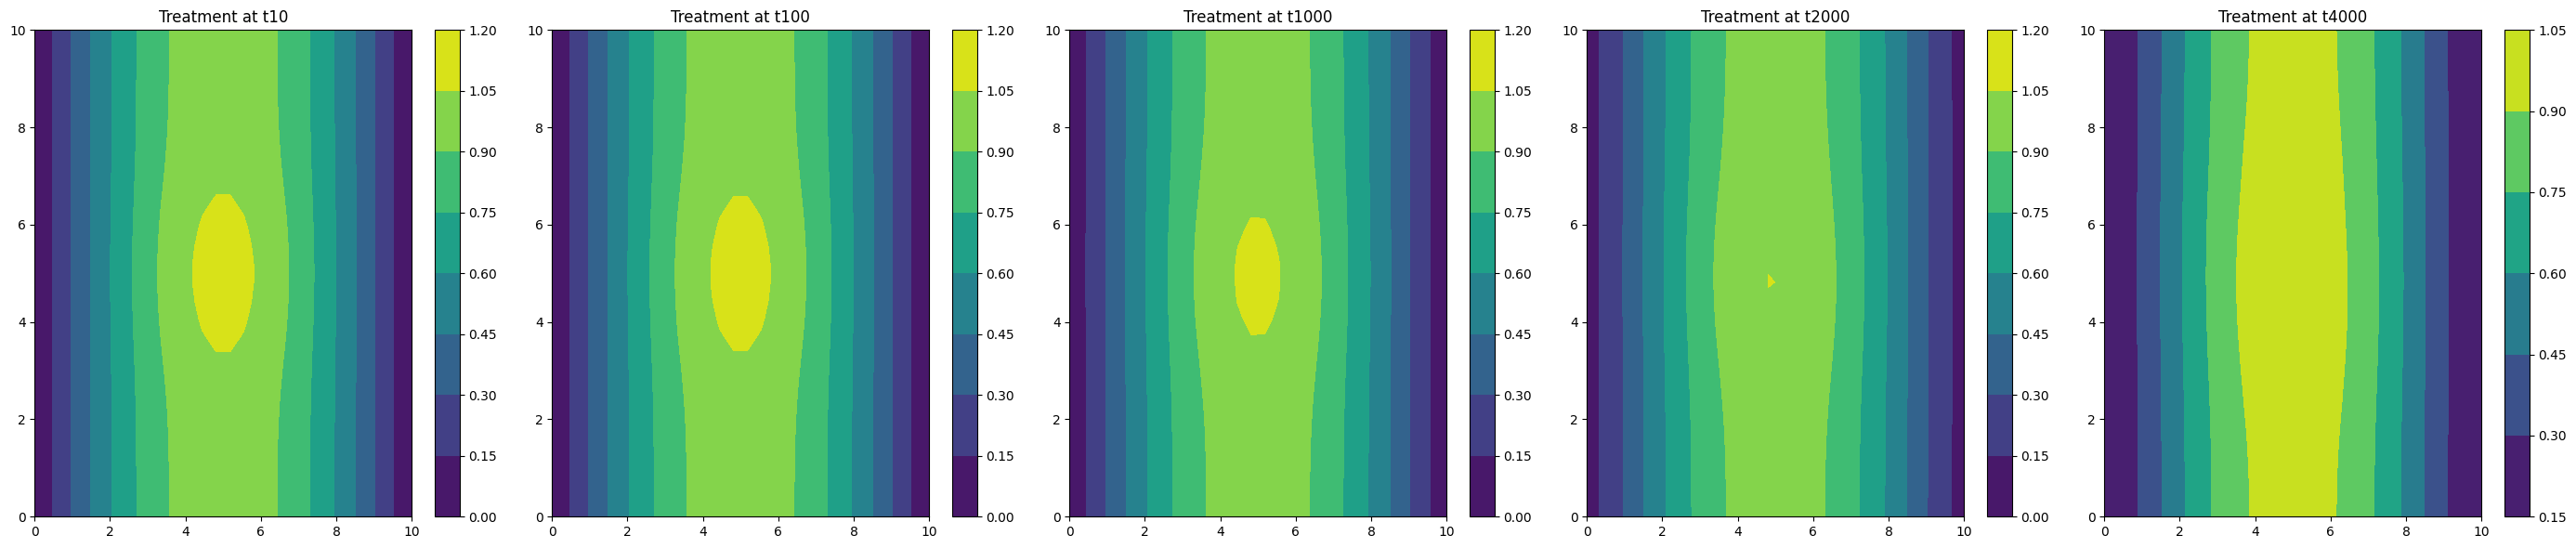

In [ ]:
# Plotting the final state of the variables
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_b[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_b[100, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_b[1000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_b[2000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_b[4000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treatment at t4000')

plt.tight_layout()
plt.show()

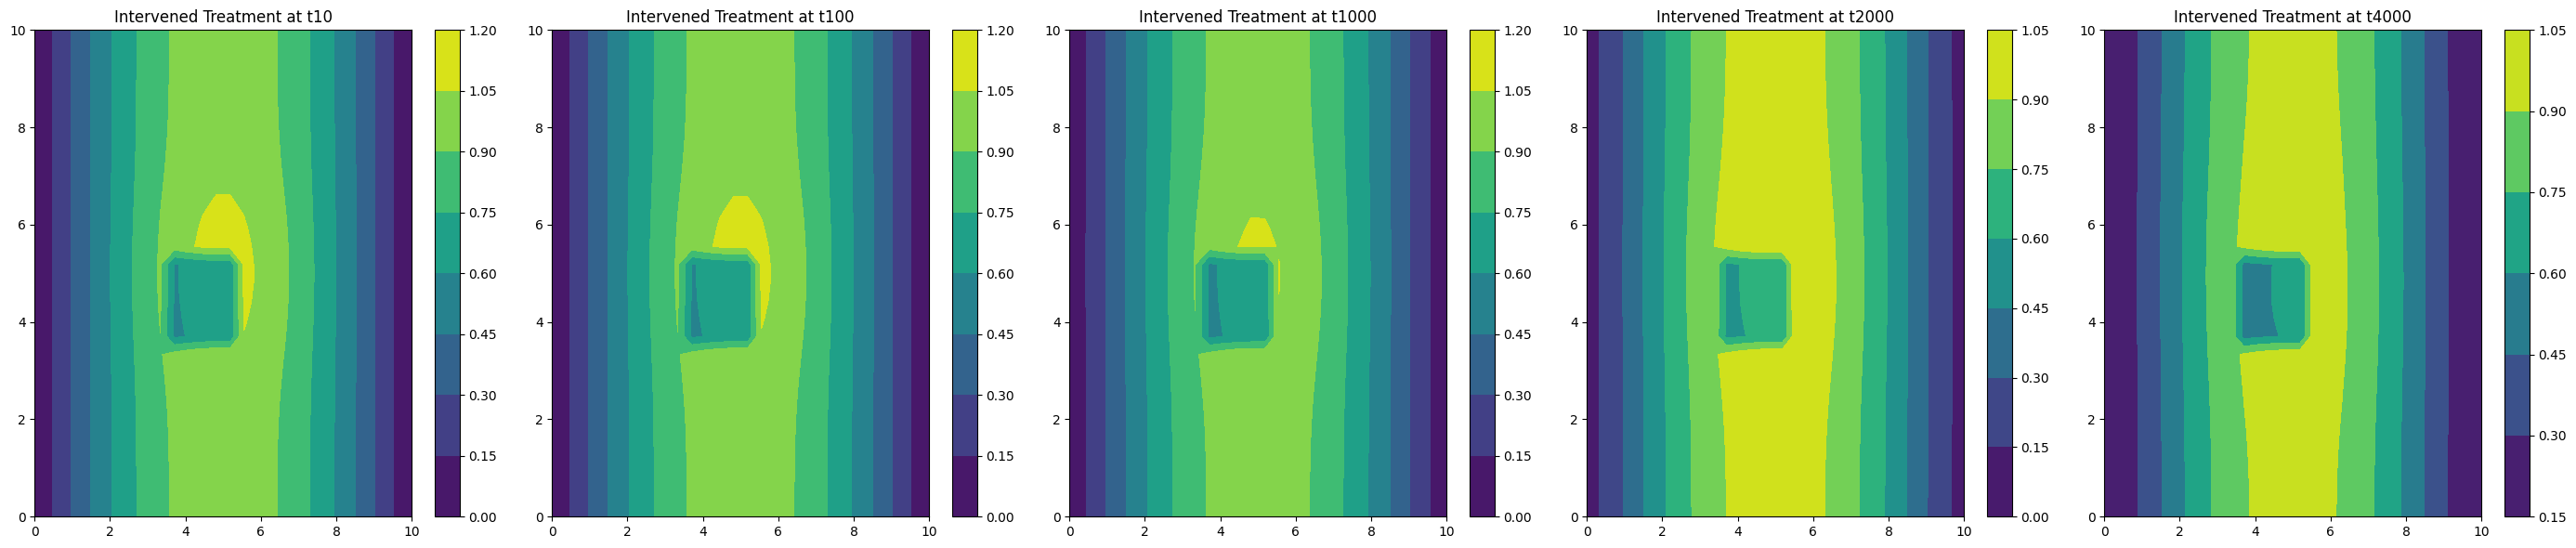

In [ ]:
# Plotting the final state of the variables
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_b_cf[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_b_cf[100, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_b_cf[1000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_b_cf[2000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_b_cf[4000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Intervened Treatment at t4000')

plt.tight_layout()
plt.show()

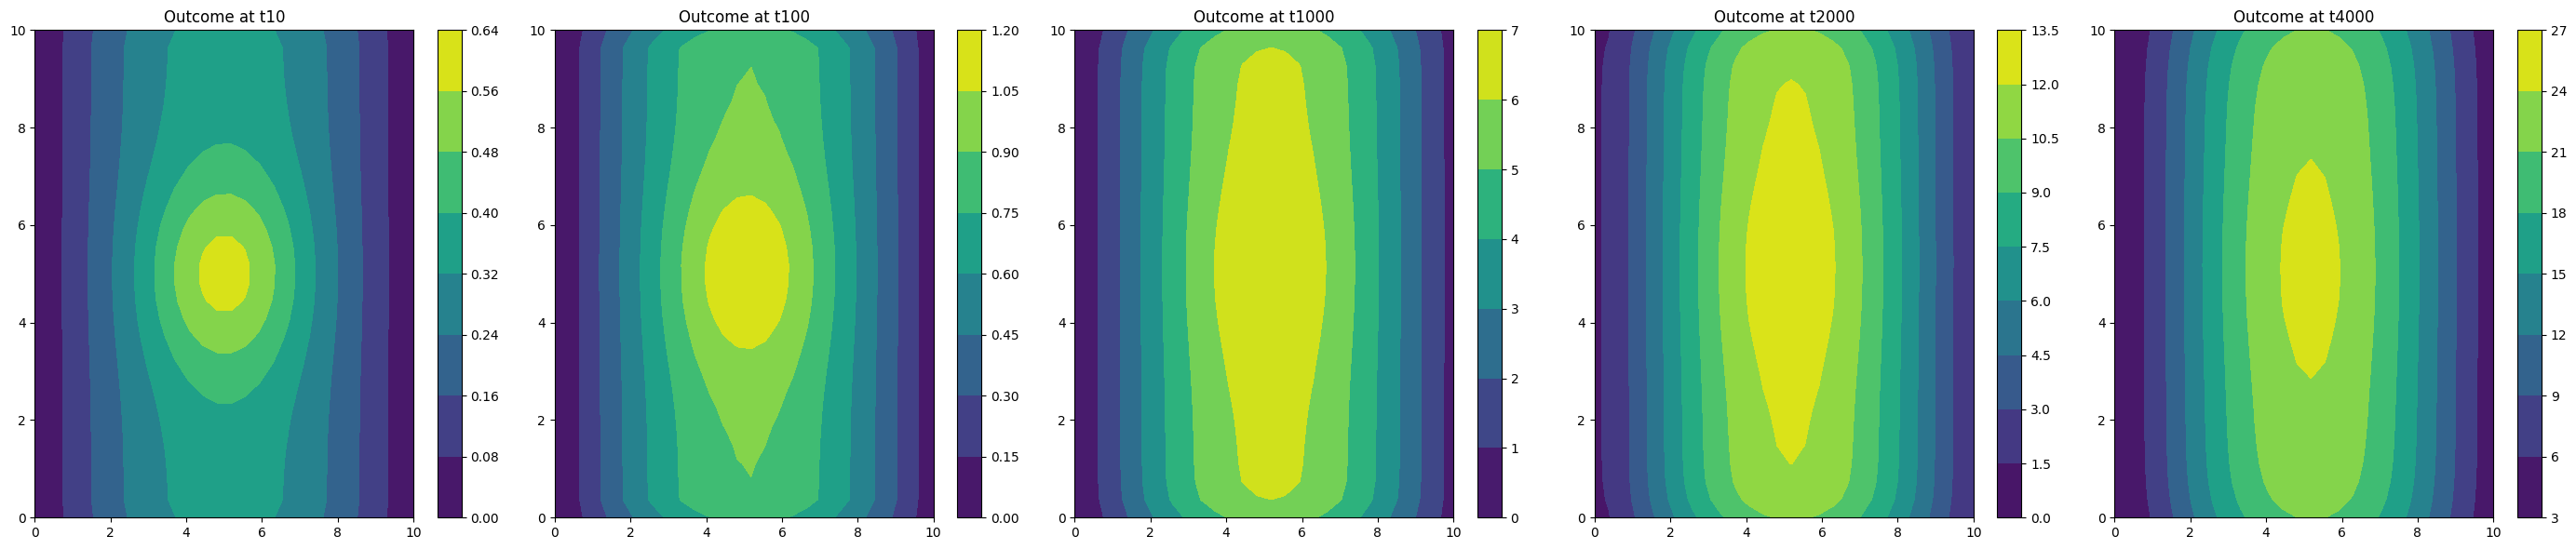

In [ ]:
# Plotting the final state of the variables
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_c[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Outcome at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_c[100, :, :], cmap='viridis')
plt.colorbar()
plt.title('Outcome at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_c[1000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Outcome at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_c[2000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Outcome at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_c[4000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Outcome at t4000')


plt.tight_layout()
plt.show()

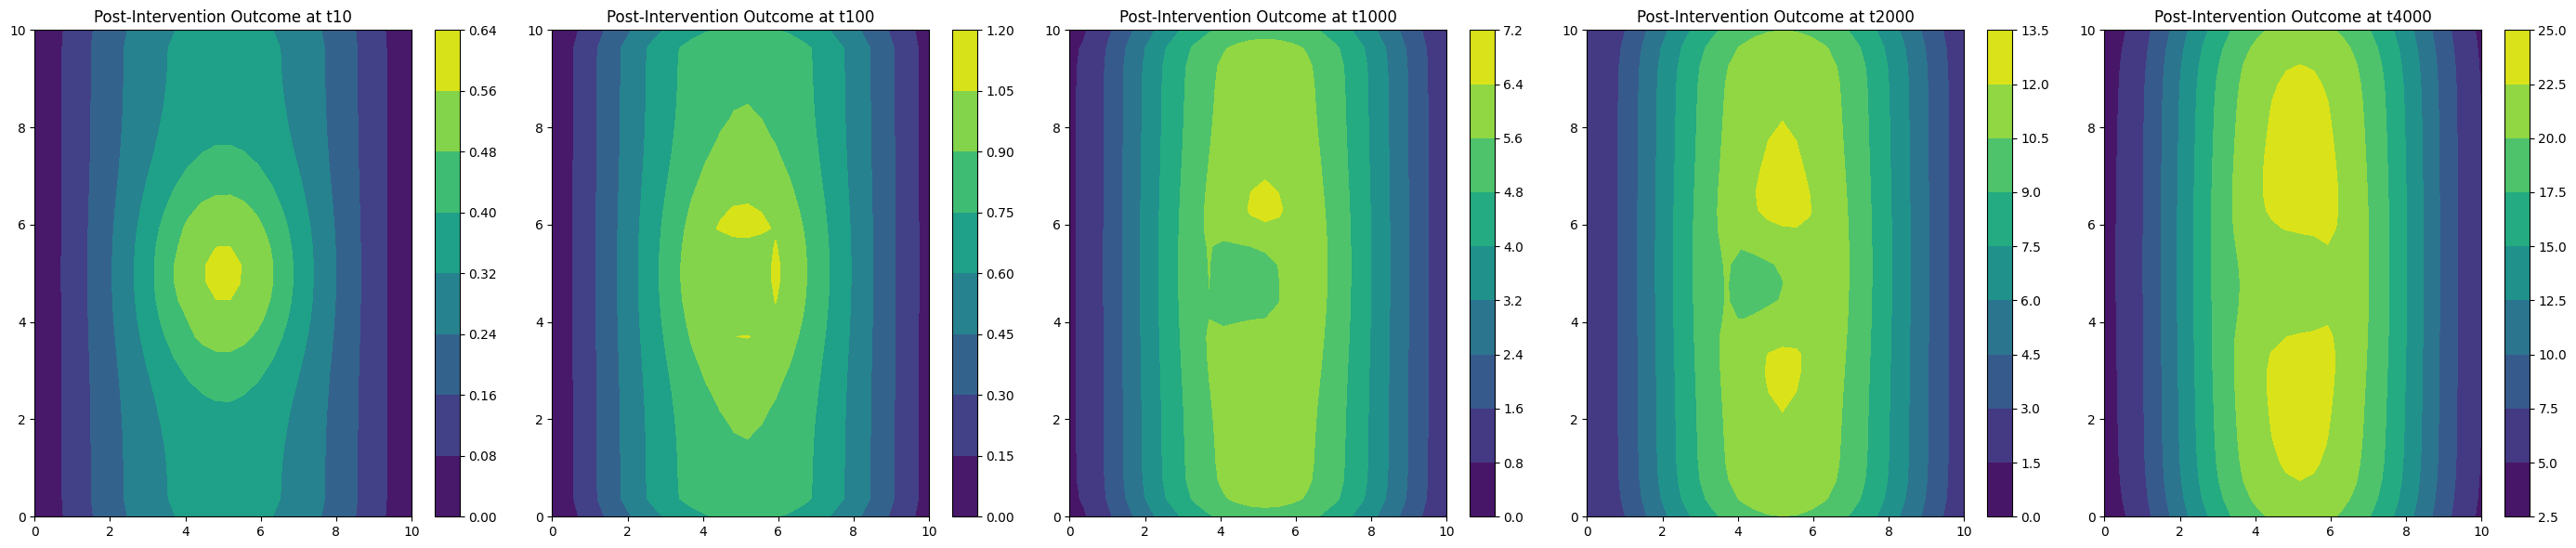

In [ ]:
# Plotting the final state of the variables
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_c_cf[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Post-Intervention Outcome at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_c_cf[100, :, :], cmap='viridis')
plt.colorbar()
plt.title('Post-Intervention Outcome at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_c_cf[1000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Post-Intervention Outcome at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_c_cf[2000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Post-Intervention Outcome at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_c_cf[4000, :, :], cmap='viridis')
plt.colorbar()
plt.title('Post-Intervention Outcome at t4000')


plt.tight_layout()
plt.show()

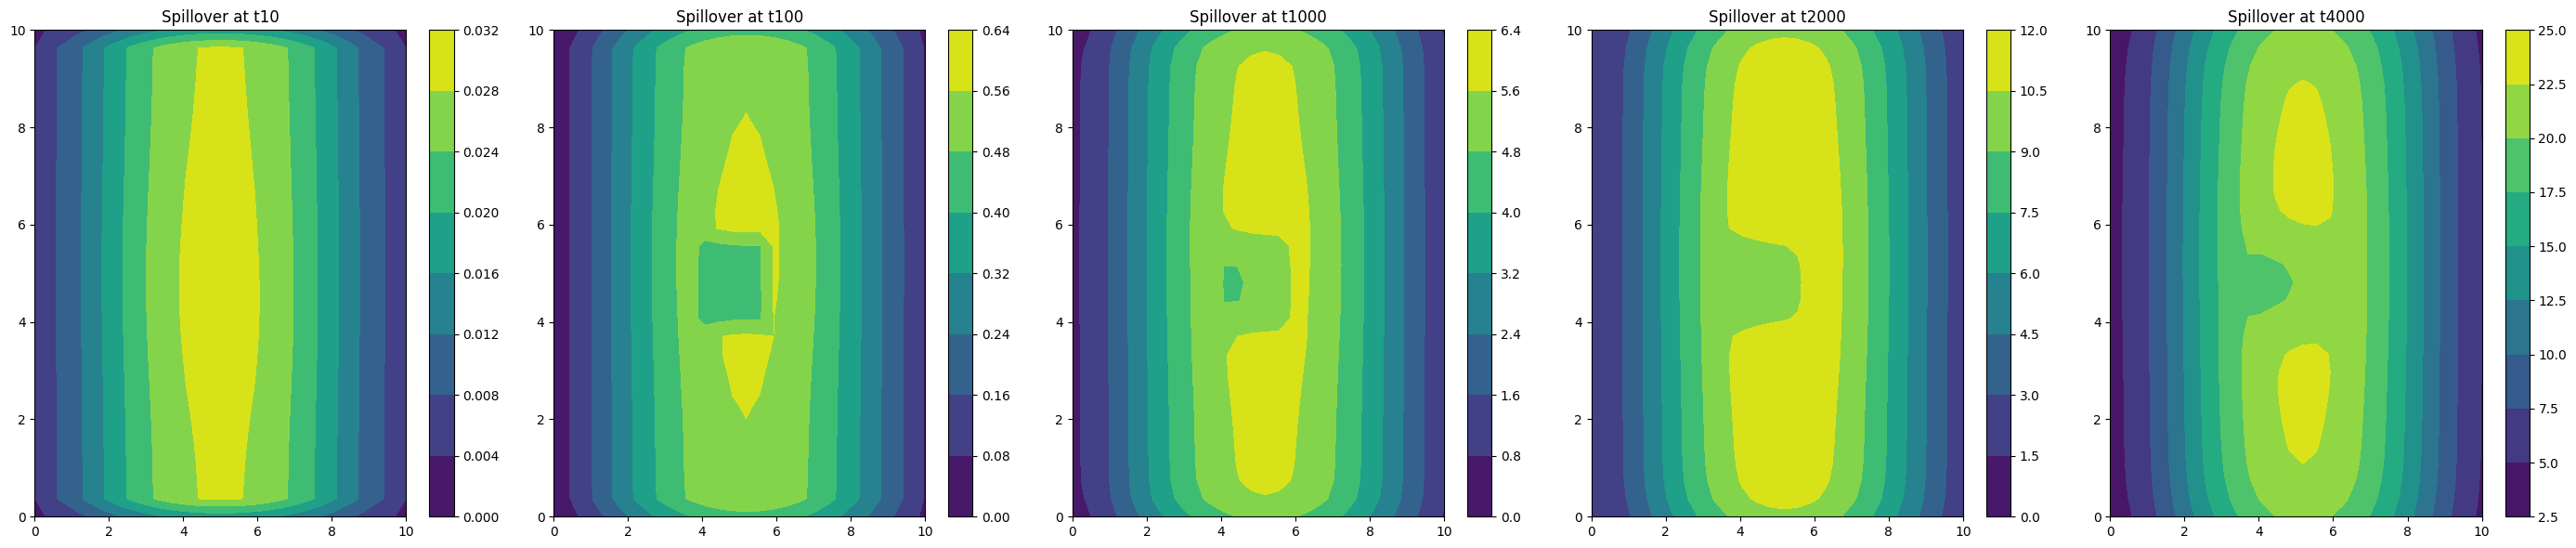

In [ ]:
# Plotting the final state of the variables
plt.figure(figsize=(28, 6))

plt.subplot(1, 5, 1)
plt.contourf(X, Y, variable_c_cf[10, :, :] - without_spill[10, :, :] , cmap='viridis')
plt.colorbar()
plt.title('Spillover at t10')

plt.subplot(1, 5, 2)
plt.contourf(X, Y, variable_c_cf[100, :, :] - without_spill[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Spillover at t100')

plt.subplot(1, 5, 3)
plt.contourf(X, Y, variable_c_cf[1000, :, :] - without_spill[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Spillover at t1000')

plt.subplot(1, 5, 4)
plt.contourf(X, Y, variable_c_cf[2000, :, :] - without_spill[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Spillover at t2000')

plt.subplot(1, 5, 5)
plt.contourf(X, Y, variable_c_cf[4000, :, :] - without_spill[10, :, :], cmap='viridis')
plt.colorbar()
plt.title('Spillover at t4000')


plt.tight_layout()
plt.show()